In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet,self).__init__()
        self.Branch_L1 = nn.Linear(100,20)
        self.Branch_L2 = nn.Linear(20,20)
        self.Branch_L3 = nn.Linear(20,20)
        self.Branch_L4 = nn.Linear(20,20)
        self.Branch_L5 = nn.Linear(20,100)

        self.Trunk_L1 = nn.Linear(2,20)
        self.Trunk_L2 = nn.Linear(20,20)
        self.Trunk_L3 = nn.Linear(20,20)
        self.Trunk_L4 = nn.Linear(20,20)
        self.Trunk_L5 = nn.Linear(20,100)

    def forward(self,y_0,x_loc_and_time):
        # Branch
        b = F.tanh(self.Branch_L1(y_0))
        b = F.tanh(self.Branch_L2(b))
        b = F.tanh(self.Branch_L3(b))
        b = F.tanh(self.Branch_L4(b))
        b = self.Branch_L5(b)

        tr = F.tanh(self.Trunk_L1(x_loc_and_time))
        tr = F.tanh(self.Trunk_L2(tr))
        tr = F.tanh(self.Trunk_L3(tr))
        tr = F.tanh(self.Trunk_L4(tr))
        tr = self.Trunk_L5(tr)

        #output = torch.matmul(b,tr.t()).sum(dim=0)
        output = torch.sum(b * tr, dim=1)

        return output

model = DeepONet().to(device)

In [5]:
import torch
import torch.nn as nn

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=64, num_layers=3):
        """
        Args:
            branch_input_dim (int): Dimension of the branch input (e.g., function discretization).
            trunk_input_dim (int): Dimension of the trunk input (e.g., coordinates in the domain).
            hidden_dim (int): Number of neurons in the hidden layers.
            num_layers (int): Number of layers in branch and trunk networks.
        """
        super(DeepONet, self).__init__()
        
        # Branch Network
        branch_layers = [nn.Linear(branch_input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            branch_layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        self.branch_net = nn.Sequential(*branch_layers)
        
        # Trunk Network
        trunk_layers = [nn.Linear(trunk_input_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers - 1):
            trunk_layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()]
        self.trunk_net = nn.Sequential(*trunk_layers)
        
        # Final layer: combines branch and trunk features
        self.basis_layer = nn.Linear(hidden_dim, hidden_dim, bias=False)  # no bias for clean dot product
    
    def forward(self, branch_input, trunk_input):
        """
        Args:
            branch_input (Tensor): Input tensor for branch network, shape [batch_size, branch_input_dim].
            trunk_input (Tensor): Input tensor for trunk network, shape [batch_size, trunk_input_dim].
        
        Returns:
            Tensor: Predicted output, shape [batch_size].
        """
        # Pass inputs through branch and trunk networks
        branch_output = self.branch_net(branch_input)  # [batch_size, hidden_dim]
        trunk_output = self.trunk_net(trunk_input)    # [batch_size, hidden_dim]
        
        # Combine using dot product
        combined_output = torch.sum(self.basis_layer(branch_output) * trunk_output, dim=1)  # [batch_size]
        
        return combined_output

# Example usage
if __name__ == "__main__":
    # Define input dimensions
    branch_input_dim = 100  # e.g., 100 points from the input function
    trunk_input_dim = 2     # e.g., x and y coordinates
    
    # Initialize DeepONet
    model = DeepONet(branch_input_dim, trunk_input_dim)
    
    # Dummy inputs
    batch_size = 8
    branch_input = torch.randn(batch_size, branch_input_dim)  # Function input samples
    trunk_input = torch.randn(batch_size, trunk_input_dim)    # Coordinate inputs
    
    # Forward pass
    output = model(branch_input, trunk_input)
    print("Output shape:", output.shape)  # Should be [batch_size]


Output shape: torch.Size([8])


In [6]:
model = DeepONet(100,2).to(device)

In [7]:
database = pd.read_csv('sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')

In [8]:
database.shape

(33000, 103)

In [9]:
class Data(Dataset):
    def __init__(self,transform=None):
        self.initial_conditions = torch.from_numpy(database[:,0:100])
        self.x_location = torch.from_numpy(database[:,[100]])
        self.time_vale = torch.from_numpy(database[:,[101]])
        self.true_y_value = torch.from_numpy(database[:,[102]])
        self.n_samples = database.shape[0]

    def __getitem__(self, index):
        return self.initial_conditions[index] , self.x_location[index] , self.time_vale[index] , self.true_y_value[index]
    
    def __len__(self):
        return self.n_samples

In [10]:
dataset_data = Data()

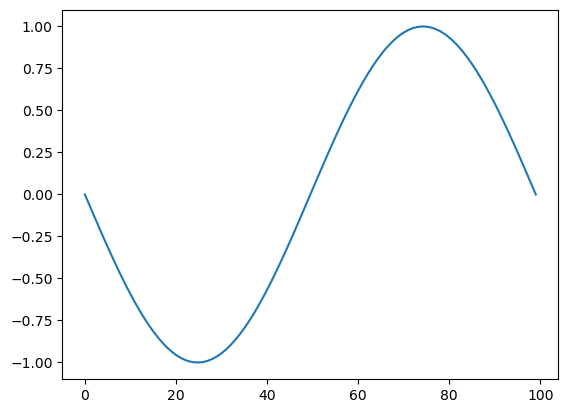

In [11]:
y,_,_,_ = dataset_data.__getitem__(1)
plt.plot(y)

In [12]:
train_size = int(0.7*dataset_data.__len__())
test_size = dataset_data.__len__() - train_size

batchsize = 2500

Burger_train_data , Burger_test_data = torch.utils.data.random_split(Data(),[train_size,test_size])

train_loader = DataLoader(dataset=Burger_train_data,batch_size=batch_size,shuffle=True)

In [13]:
data_iter = iter(train_loader)
data = data_iter.__next__()
Init_val , x_loc, time, y_value = data

In [14]:
num_epoch = 10
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/300)
print(total_samples,n_iterations)
learning_rate = 0.01

criterion = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.1)

loss_rec = []

2888 10


In [21]:
model.train()

for epoch in range(num_epoch):
    for i , (input_init_conditions,input_x_loc,input_time,Actual_y) in enumerate(train_loader):
        input1 = input_init_conditions
        input1 = input1.to(device)

        input2 = torch.cat((input_x_loc,input_time),-1)
        input2 = input2.to(device)

        Actual_y = Actual_y.to(device)

        Outputs = model(input1,input2)
        loss = criterion(Outputs,Actual_y)


        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss_rec.append(loss.item())

        if (i+1) % 10 ==0:
            print(f'Epoch [{epoch+1}/{num_epoch}] , Step [{i+1}/{total_samples}] , Loss: {loss.item():.16f}')

c:\Users\dell\anaconda3\envs\abhi\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10] , Step [10/2888] , Loss: 0.6074839830398560
Epoch [1/10] , Step [20/2888] , Loss: 0.5669051408767700
Epoch [1/10] , Step [30/2888] , Loss: 0.4830687046051025
Epoch [1/10] , Step [40/2888] , Loss: 0.5410313010215759
Epoch [1/10] , Step [50/2888] , Loss: 0.5452060699462891
Epoch [1/10] , Step [60/2888] , Loss: 0.3254669308662415
Epoch [1/10] , Step [70/2888] , Loss: 0.4217885136604309
Epoch [1/10] , Step [80/2888] , Loss: 0.2965095341205597
Epoch [1/10] , Step [90/2888] , Loss: 0.4818367660045624
Epoch [1/10] , Step [100/2888] , Loss: 0.5568741559982300
Epoch [1/10] , Step [110/2888] , Loss: 0.3839237987995148
Epoch [1/10] , Step [120/2888] , Loss: 0.1718582063913345
Epoch [1/10] , Step [130/2888] , Loss: 0.4819245934486389
Epoch [1/10] , Step [140/2888] , Loss: 0.1567747890949249
Epoch [1/10] , Step [150/2888] , Loss: 0.4383225440979004
Epoch [1/10] , Step [160/2888] , Loss: 0.6023303270339966
Epoch [1/10] , Step [170/2888] , Loss: 0.5035705566406250
Epoch [1/10] , Step [18

c:\Users\dell\anaconda3\envs\abhi\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/10] , Step [40/2888] , Loss: 0.3972056508064270
Epoch [2/10] , Step [50/2888] , Loss: 0.5260297656059265
Epoch [2/10] , Step [60/2888] , Loss: 0.4793160259723663
Epoch [2/10] , Step [70/2888] , Loss: 0.5819978117942810
Epoch [2/10] , Step [80/2888] , Loss: 0.3787530064582825
Epoch [2/10] , Step [90/2888] , Loss: 0.4273822307586670
Epoch [2/10] , Step [100/2888] , Loss: 0.3846902251243591
Epoch [2/10] , Step [110/2888] , Loss: 0.6422303318977356
Epoch [2/10] , Step [120/2888] , Loss: 0.5362609028816223
Epoch [2/10] , Step [130/2888] , Loss: 0.5863925218582153
Epoch [2/10] , Step [140/2888] , Loss: 0.3073419928550720
Epoch [2/10] , Step [150/2888] , Loss: 0.5299744009971619
Epoch [2/10] , Step [160/2888] , Loss: 0.6341608762741089
Epoch [2/10] , Step [170/2888] , Loss: 0.3075975179672241
Epoch [2/10] , Step [180/2888] , Loss: 0.5627171397209167
Epoch [2/10] , Step [190/2888] , Loss: 0.7179961800575256
Epoch [2/10] , Step [200/2888] , Loss: 0.4814790785312653
Epoch [2/10] , Step 

In [16]:
input_time.size(0)
torch.ones(input_time.size(0),1)

tensor([[1.],
        [1.],
        [1.],
        [1.]])

In [17]:
input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)
input2_BC1

tensor([[0.0000, 0.1222],
        [0.0000, 0.0631],
        [0.0000, 0.2255],
        [0.0000, 0.0912]])

In [18]:
target_BC1 = torch.zeros(input_time.size(0))
target_BC1

tensor([0., 0., 0., 0.])

In [19]:
predicted_BC1 = model(input1,input2_BC1)
# predicted_BC1
loss_BC1 = torch.mean((predicted_BC1-target_BC1)**2)
loss_BC1

tensor(0.0050, grad_fn=<MeanBackward0>)

In [20]:
loss_BC_0 = torch.mean()

TypeError: mean() received an invalid combination of arguments - got (), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [22]:
input2.size()

torch.Size([4, 2])

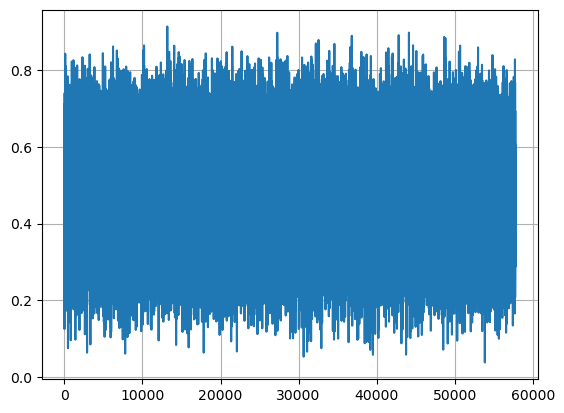

In [23]:
plt.plot(loss_rec)
plt.grid()

In [24]:
model(y,torch.tensor([0,0]))

RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [41]:
trial_input_1 = torch.tensor(np.random.rand(65,100),dtype=torch.float32).to(device)
trial_input_2 = torch.tensor(np.random.rand(65,2),dtype=torch.float32).to(device)
model(trial_input_1,trial_input_2).mean()
model(trial_input_1,trial_input_2).shape

torch.Size([65])